# Проект: Прогнозирование оттока клиентов телеком компании

## Описание проекта

Оператор связи «Ниединогоразрыва.ком» хочет научиться прогнозировать отток клиентов. Если выяснится, что пользователь планирует уйти, ему будут предложены промокоды и специальные условия. Команда оператора собрала персональные данные о некоторых клиентах, информацию об их тарифах и договорах.

## Описание данных

Данные состоят из файлов, полученных из разных источников:
- `contract.csv` — информация о договоре;
- `personal.csv` — персональные данные клиента;
- `internet.csv` — информация об интернет-услугах;
- `phone.csv` — информация об услугах телефонии.  
  
Во всех файлах столбец `customerID` содержит код клиента.  
Информация о договорах актуальна на 1 февраля 2020.

## Задача

На основе данных спрогнозировать поведение клиентов ().

**План работы:**
1. Загрузка данных и изучение общей информации
   1. Просмотр датафреймов
   2. Изучение общей информации
   3. Изучение статистических показателей
   


2. Предобработка данных  

   1. Изучение типов данных в каждом столбце
   3. Устранение неявных и явных дубликатов
   1. Обработка пропущенных значений в столбцах
   4. Обработка аномальных значений
   5. Кодирование категориальных переменных
  
3. Исследовательский анализ данных
   1. Изучение уникальных значений каждого столбца
   1. Анализ распределений значений столбцов
   1. Анализ дисбаланса классов
   2. Проверка наличия мультиколлинеарности
   3. Отбор признаков для обучения

5. Обучение модели
   1. Разделение данных на выборки
   2. Подбор гиперпараметров модели
   3. Выбор лучшей модели
   4. Проверка модели на тестовой выборке
6. Вывод

# Загрузка данных и изучение общей информации

In [1467]:

import pandas as pd
import os
import datetime as dt
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

from sklearn.metrics import (auc, roc_curve, roc_auc_score, accuracy_score, 
                             precision_score, recall_score, confusion_matrix)
from sklearn.model_selection import (train_test_split, 
                                     GridSearchCV, RandomizedSearchCV)
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier 

from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier


In [1468]:
path = '/datasets/final_provider/'
if not os.path.exists(path):
    path = '../DataFrames/'

In [1469]:
df_contract = pd.read_csv(os.path.join(path, 'contract.csv'))
df_personal = pd.read_csv(os.path.join(path, 'personal.csv'))
df_internet = pd.read_csv(os.path.join(path, 'internet.csv'))
df_phone = pd.read_csv(os.path.join(path, 'phone.csv'))

In [1470]:
def print_data_info(df: pd.DataFrame) -> None:
    '''Print database information'''
    display(df.head())
    print(df.info())
    print(df.describe())
    print('------------------------------------------------------------------------------------------------------------')
    

In [1471]:
print_data_info(df_contract)


,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   customerID        7043 non-null   object 
 1   BeginDate         7043 non-null   object 
 2   EndDate           7043 non-null   object 
 3   Type              7043 non-null   object 
 4   PaperlessBilling  7043 non-null   object 
 5   PaymentMethod     7043 non-null   object 
 6   MonthlyCharges    7043 non-null   float64
 7   TotalCharges      7043 non-null   object 
dtypes: float64(1), object(7)
memory usage: 440.3+ KB
None
       MonthlyCharges
count     7043.000000
mean        64.761692
std         30.090047
min         18.250000
25%         35.500000
50%         70.350000
75%         89.850000
max        118.750000
------------------------------------------------------------------------------------------------------------


In [1472]:
print_data_info(df_personal)

,customerID,gender,SeniorCitizen,Partner,Dependents
0,7590-VHVEG,Female,0,Yes,No
1,5575-GNVDE,Male,0,No,No
2,3668-QPYBK,Male,0,No,No
3,7795-CFOCW,Male,0,No,No
4,9237-HQITU,Female,0,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     7043 non-null   object
 1   gender         7043 non-null   object
 2   SeniorCitizen  7043 non-null   int64 
 3   Partner        7043 non-null   object
 4   Dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB
None
       SeniorCitizen
count    7043.000000
mean        0.162147
std         0.368612
min         0.000000
25%         0.000000
50%         0.000000
75%         0.000000
max         1.000000
------------------------------------------------------------------------------------------------------------


In [1473]:
print_data_info(df_internet)


,customerID,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies
0,7590-VHVEG,DSL,No,Yes,No,No,No,No
1,5575-GNVDE,DSL,Yes,No,Yes,No,No,No
2,3668-QPYBK,DSL,Yes,Yes,No,No,No,No
3,7795-CFOCW,DSL,Yes,No,Yes,Yes,No,No
4,9237-HQITU,Fiber optic,No,No,No,No,No,No


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5517 entries, 0 to 5516
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype 
---  ------            --------------  ----- 
 0   customerID        5517 non-null   object
 1   InternetService   5517 non-null   object
 2   OnlineSecurity    5517 non-null   object
 3   OnlineBackup      5517 non-null   object
 4   DeviceProtection  5517 non-null   object
 5   TechSupport       5517 non-null   object
 6   StreamingTV       5517 non-null   object
 7   StreamingMovies   5517 non-null   object
dtypes: object(8)
memory usage: 344.9+ KB
None
        customerID InternetService OnlineSecurity OnlineBackup  \
count         5517            5517           5517         5517   
unique        5517               2              2            2   
top     7590-VHVEG     Fiber optic             No           No   
freq             1            3096           3498         3088   

       DeviceProtection TechSupport StreamingTV Streamin

In [1474]:
print_data_info(df_phone)

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerID     6361 non-null   object
 1   MultipleLines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB
None
        customerID MultipleLines
count         6361          6361
unique        6361             2
top     5575-GNVDE            No
freq             1          3390
------------------------------------------------------------------------------------------------------------


Все таблицы имеют общий столбец `customerID`. Датафреймы df_contract и df_personal содержат 7043 строк (), датафрейм df_internet - 5517
df_phone - 6361. 

# Предобработка данных

Перед обьединением таблиц нужно проверить наличие пропусков в df_internet и df_phone, чтобы верно выполнить обьединение.

In [1475]:
# Подсчет пропусков в процентах
pd.DataFrame(df_internet.isna().mean()*100,).style.background_gradient('coolwarm')

,0
customerID,0.000000
InternetService,0.000000
OnlineSecurity,0.000000
OnlineBackup,0.000000
DeviceProtection,0.000000
TechSupport,0.000000
StreamingTV,0.000000
StreamingMovies,0.000000


In [1476]:
# Подсчет пропусков в процентах
pd.DataFrame(df_phone.isna().mean()*100,).style.background_gradient('coolwarm')

,0
customerID,0.000000
MultipleLines,0.000000


Отсутствие пропусков говорит о том, что если ID клиента нет в этих таблицах, это значит, что клиент не подключал интернет и/или не подключал услуги телефонии. Необходимо соединить таблицы без потери информаци об этих клиентах.

In [1477]:
# Объединение таблиц
df = df_contract.merge(df_personal, how='inner', on='customerID')
df = df.merge(df_internet, how='left', on='customerID')
df = df.merge(df_phone, how='left', on='customerID')

In [1478]:
df.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,gender,SeniorCitizen,Partner,Dependents,InternetService,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,MultipleLines
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,Female,0,Yes,No,DSL,No,Yes,No,No,No,No,NaN
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5,Male,0,No,No,DSL,Yes,No,Yes,No,No,No,No
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,Male,0,No,No,DSL,Yes,Yes,No,No,No,No,No
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,Male,0,No,No,DSL,Yes,No,Yes,Yes,No,No,NaN
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,Female,0,No,No,Fiber optic,No,No,No,No,No,No,No


Признак BeginDate и EndDate неиформативны для предсказания ухода клиента, но на основании этих столбцов можно сгенерировать новый признак - количество дней/месяцев, в течении которых клиент пользуется услугами.

In [1479]:
df.columns = df.columns.str.lower() # Приведение к нижнему регистру названий столбцов
print(df.columns)

Index(['customerid', 'begindate', 'enddate', 'type', 'paperlessbilling',
       'paymentmethod', 'monthlycharges', 'totalcharges', 'gender',
       'seniorcitizen', 'partner', 'dependents', 'internetservice',
       'onlinesecurity', 'onlinebackup', 'deviceprotection', 'techsupport',
       'streamingtv', 'streamingmovies', 'multiplelines'],
      dtype='object')


In [1480]:
# Приведение названий столбцов к змеиному регистру
df = df.rename(columns={'customerid':'customer_id',
                        'begindate':'begin_date',
                        'enddate':'end_date',
                        'paperlessbilling':'paperless_billing',
                        'paymentmethod':'payment_method',
                        'monthlycharges':'monthly_charges',
                        'totalcharges':'total_charges',
                        'seniorcitizen':'senior_citizen',
                        'internetservice':'internet_service',
                        'onlinesecurity':'online_security',
                        'onlinebackup':'online_backup',
                        'deviceprotection':'device_protection',
                        'techsupport':'tech_support',
                        'streamingtv':'streaming_tv',
                        'streamingmovies':'streaming_movies',
                        'multiplelines':'multiple_lines'})

In [1481]:
# Генерация нового признака 
# Нахождение разницы между датой начала использования услуг и датой выгрузки данных
df.loc[
    df['end_date'] == 'No', 'usage_period_in_days'
    ] = df.loc[
    df['end_date'] == 'No','begin_date'
              ].apply(
    lambda x: (dt.datetime(2020,2,1) 
    - dt.datetime.strptime(x, "%Y-%m-%d")
              ).days) 
              
# Нахождение разницы между датой начала использования услуг и датой окончания 
df.loc[
    df['end_date'] != 'No', 'usage_period_in_days'
    ] = df.loc[
    df['end_date'] != 'No'
              ].apply(
    lambda x: (dt.datetime.strptime(x['end_date'], "%Y-%m-%d %H:%M:%S")
    - dt.datetime.strptime(x['begin_date'], "%Y-%m-%d")
    ).days, axis=1) 



In [1482]:
df['customer_id'].unique

<bound method Series.unique of 0       7590-VHVEG
1       5575-GNVDE
2       3668-QPYBK
3       7795-CFOCW
4       9237-HQITU
           ...    
7038    6840-RESVB
7039    2234-XADUH
7040    4801-JZAZL
7041    8361-LTMKD
7042    3186-AJIEK
Name: customer_id, Length: 7043, dtype: object>

Уникальные идентификаторы не дублируются

In [1483]:
df.duplicated().sum() # Проверка на явные дубликаты

0

In [1484]:
# Подсчет пропусков в процентах
pd.DataFrame(df.isna().mean()*100,).style.background_gradient('coolwarm')

,0
customer_id,0.000000
begin_date,0.000000
end_date,0.000000
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
gender,0.000000
senior_citizen,0.000000


In [1485]:
# Генерация целевого признака
df['churn'] = df['end_date'].where(df['end_date'] == 'No', other='Yes') # Если указана end_date, значит клиент ушел

In [1486]:
df['churn'].unique()

array(['No', 'Yes'], dtype=object)

In [1487]:
columns_with_gaps = df.loc[:, df.isnull().any()].columns
for column in columns_with_gaps: # Уникальные значения каждого столбца c пропусками
    print(column)
    print(df[column].unique())
    print(len(df[column].unique()))
    print('-----------------------')
    print()

internet_service
['DSL' 'Fiber optic' nan]
3
-----------------------

online_security
['No' 'Yes' nan]
3
-----------------------

online_backup
['Yes' 'No' nan]
3
-----------------------

device_protection
['No' 'Yes' nan]
3
-----------------------

tech_support
['No' 'Yes' nan]
3
-----------------------

streaming_tv
['No' 'Yes' nan]
3
-----------------------

streaming_movies
['No' 'Yes' nan]
3
-----------------------

multiple_lines
[nan 'No' 'Yes']
3
-----------------------



In [1488]:
# Заполнение пропусков
df.fillna('No', inplace=True)

In [1489]:
# Подсчет пропусков в процентах
pd.DataFrame(df.isna().mean()*100,).style.background_gradient('coolwarm')

,0
customer_id,0.000000
begin_date,0.000000
end_date,0.000000
type,0.000000
paperless_billing,0.000000
payment_method,0.000000
monthly_charges,0.000000
total_charges,0.000000
gender,0.000000
senior_citizen,0.000000


In [1490]:
for column in df.columns: # Уникальные значения каждого столбца
    print(column)
    print(df[column].unique())
    print(len(df[column].unique()))
    print('-----------------------')
    print()

customer_id
['7590-VHVEG' '5575-GNVDE' '3668-QPYBK' ... '4801-JZAZL' '8361-LTMKD'
 '3186-AJIEK']
7043
-----------------------

begin_date
['2020-01-01' '2017-04-01' '2019-10-01' '2016-05-01' '2019-09-01'
 '2019-03-01' '2018-04-01' '2019-04-01' '2017-07-01' '2014-12-01'
 '2019-01-01' '2018-10-01' '2015-04-01' '2015-09-01' '2018-01-01'
 '2014-05-01' '2015-10-01' '2014-03-01' '2018-05-01' '2019-11-01'
 '2019-02-01' '2016-01-01' '2017-08-01' '2015-12-01' '2014-02-01'
 '2018-06-01' '2019-12-01' '2017-11-01' '2019-06-01' '2016-04-01'
 '2017-02-01' '2018-12-01' '2014-04-01' '2018-09-01' '2014-11-01'
 '2016-07-01' '2015-02-01' '2018-07-01' '2014-08-01' '2016-03-01'
 '2018-08-01' '2014-10-01' '2015-06-01' '2016-08-01' '2019-05-01'
 '2017-03-01' '2016-02-01' '2017-09-01' '2014-09-01' '2017-12-01'
 '2016-12-01' '2017-06-01' '2015-05-01' '2016-10-01' '2016-09-01'
 '2019-08-01' '2019-07-01' '2017-05-01' '2017-10-01' '2014-07-01'
 '2018-03-01' '2015-01-01' '2018-11-01' '2015-03-01' '2018-02-01'
 '20

In [1491]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   customer_id           7043 non-null   object 
 1   begin_date            7043 non-null   object 
 2   end_date              7043 non-null   object 
 3   type                  7043 non-null   object 
 4   paperless_billing     7043 non-null   object 
 5   payment_method        7043 non-null   object 
 6   monthly_charges       7043 non-null   float64
 7   total_charges         7043 non-null   object 
 8   gender                7043 non-null   object 
 9   senior_citizen        7043 non-null   int64  
 10  partner               7043 non-null   object 
 11  dependents            7043 non-null   object 
 12  internet_service      7043 non-null   object 
 13  online_security       7043 non-null   object 
 14  online_backup         7043 non-null   object 
 15  device_protection    

In [1492]:
df['monthly_charges'] = np.float64(df['monthly_charges'])
#df['total_charges'] = np.float64(df['total_charges']) Возникла ошибка

In [1493]:
for index in df.index:
    item = df.loc[index, 'total_charges']
    try:
        a = np.float64(item)
    except Exception as e:
        print(index, " item = ", item, " exc = ", e)
        


488  item =     exc =  could not convert string to float: ''
753  item =     exc =  could not convert string to float: ''
936  item =     exc =  could not convert string to float: ''
1082  item =     exc =  could not convert string to float: ''
1340  item =     exc =  could not convert string to float: ''
3331  item =     exc =  could not convert string to float: ''
3826  item =     exc =  could not convert string to float: ''
4380  item =     exc =  could not convert string to float: ''
5218  item =     exc =  could not convert string to float: ''
6670  item =     exc =  could not convert string to float: ''
6754  item =     exc =  could not convert string to float: ''


In [1494]:
df.loc[df['total_charges'] == ' ', ['begin_date','end_date','type', 'monthly_charges','total_charges' ]]

,begin_date,end_date,type,monthly_charges,total_charges
488,2020-02-01,No,Two year,52.55,
753,2020-02-01,No,Two year,20.25,
936,2020-02-01,No,Two year,80.85,
1082,2020-02-01,No,Two year,25.75,
1340,2020-02-01,No,Two year,56.05,
3331,2020-02-01,No,Two year,19.85,
3826,2020-02-01,No,Two year,25.35,
4380,2020-02-01,No,Two year,20.00,
5218,2020-02-01,No,One year,19.70,
6670,2020-02-01,No,Two year,73.35,


In [1495]:
df.loc[df['total_charges'] == ' ', 'total_charges' ] = 0

11 пропусков в поле с суммарными тратами, однако все они у клиентов, подключившихся в месяц выгрузки данных, такие значения далее заменим нулями. 

In [1496]:
df['total_charges'] = np.float64(df['total_charges']) 
df['senior_citizen'] = np.int8(df['senior_citizen'])
df['usage_period_in_days'] = np.int64(df['usage_period_in_days'])
df['begin_date'] = pd.to_datetime(df['begin_date'], format='%Y-%m-%d')

In [1497]:
df.loc[df['churn'] == 'Yes', 'churn'] = 1
df.loc[df['churn'] == 'No', 'churn'] = 0

In [1498]:
cols_to_exclude = ['total_charges', 'monthly_charges', 'usage_period_in_days', 'customer_id', 'begin_date', 'end_date','churn']

for col in df.columns:
    if df[col].nunique() < 100 and col not in cols_to_exclude:
        df[col] = df[col].astype('category')

In [1499]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 22 columns):
 #   Column                Non-Null Count  Dtype         
---  ------                --------------  -----         
 0   customer_id           7043 non-null   object        
 1   begin_date            7043 non-null   datetime64[ns]
 2   end_date              7043 non-null   object        
 3   type                  7043 non-null   category      
 4   paperless_billing     7043 non-null   category      
 5   payment_method        7043 non-null   category      
 6   monthly_charges       7043 non-null   float64       
 7   total_charges         7043 non-null   float64       
 8   gender                7043 non-null   category      
 9   senior_citizen        7043 non-null   category      
 10  partner               7043 non-null   category      
 11  dependents            7043 non-null   category      
 12  internet_service      7043 non-null   category      
 13  online_security   

Таблицы соединены, названия столбцов приведены к змеинному регистру, пропуски заполнены значениями 'No', сгенерирован новый признак 'usage_period_in_days' (период использования услуг в днях) и целевая переменная 'is_client_left', данные приведены к соответствующим типам.

# Исследовательский анализ

In [1500]:
def plot_value_counts(series, n_values=15, show_percents=True): 
    ''' Визуализация количества встречающихся значений в pd.Series

    Параметры
    ---
        `series` : pd.Series
        `n_values` : int - максимальное количество значений для отображения на диаграмме
        `show_percents`: bool - показывать долю значений в процентах
    '''
    if series.dtype == 'category':
        plt.rcParams["figure.figsize"] = (6,2)
        sorted_series = df.groupby(series.name)[series.name].count().sort_values(ascending=False)
        ax = sns.barplot(x=sorted_series.values[:n_values], y=sorted_series.index[:n_values], order=sorted_series.index[:n_values])
        ax.set_title(series.name, fontsize=10)
        plt.xlabel("quantity", fontsize=10, color = 'black')
        plt.ylabel("quantity", fontsize=10, color = 'black')
        plt.tick_params(axis='both', which='major', labelsize=10)

        if show_percents:
            labels = [f'{w/sorted_series.sum()*100:0.1f}%' 
                        if (w := v.get_width()) > 0 else '' for v in ax.containers[0]]
        else:
            labels = sorted_series
        plt.bar_label(ax.containers[0], labels=labels, label_type='center', fontsize=10, color = 'white')
        plt.show()



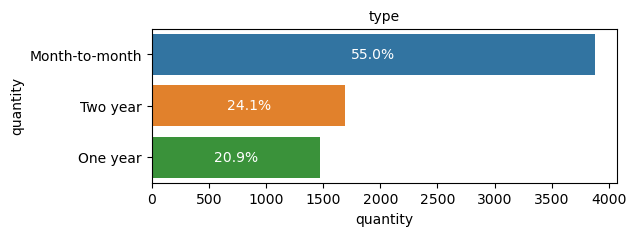

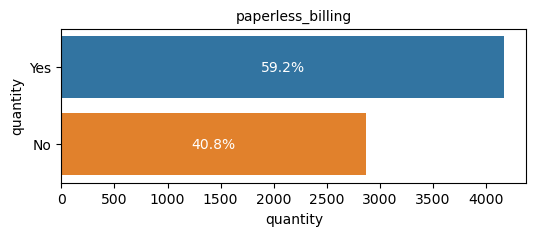

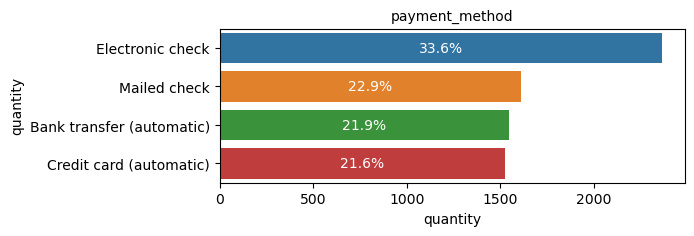

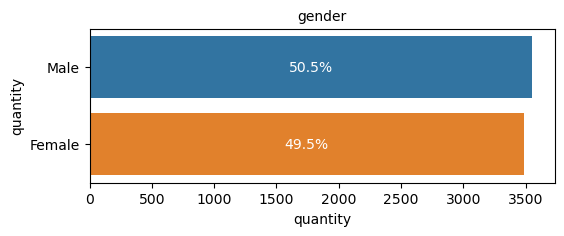

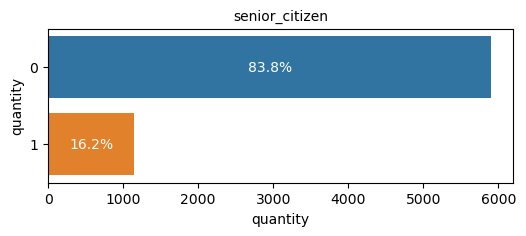

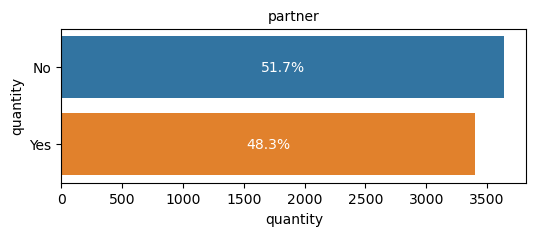

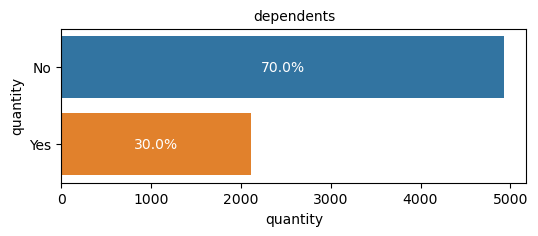

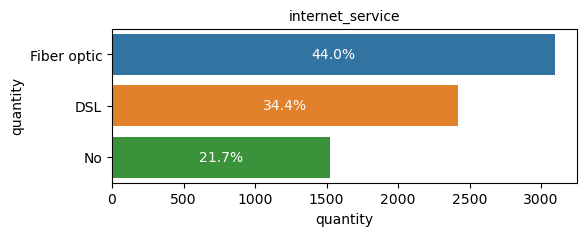

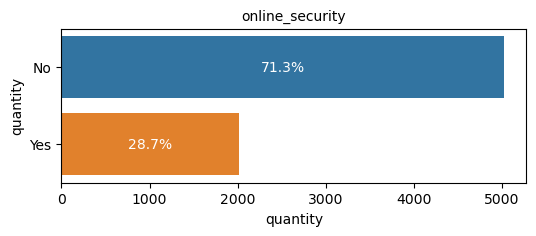

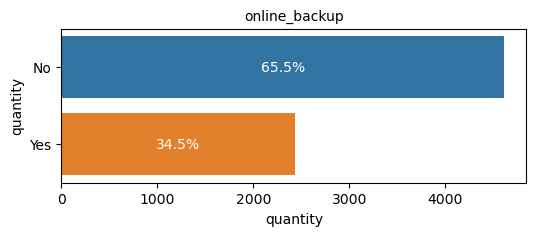

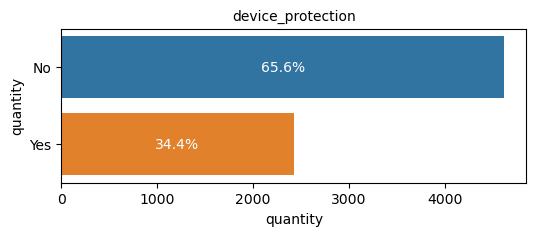

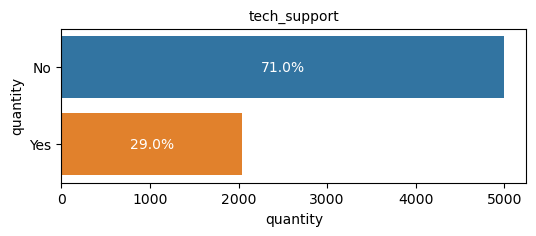

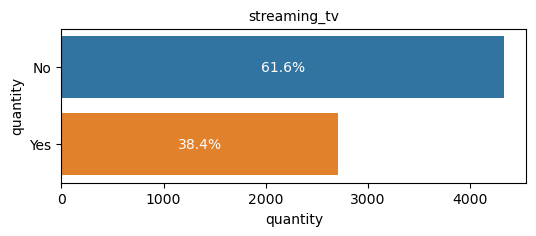

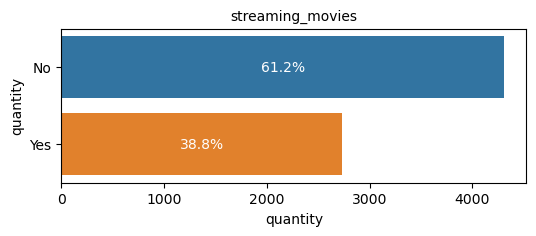

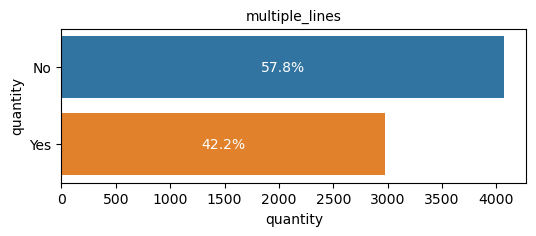

In [1501]:
for column in df.columns:
    plot_value_counts(df[column])

Не все классы сбалансированы.
- Большинство клиентов оплачивает услуги помесячно
- Около 60 процентов клиентов получают счета в электронном виде
- Самый популярный способ оплаты - с помощью электронного чека
- Доля клиентов пенсионного возраста невелика
- Клиентов, состоящих в браке и не состоящих в нём примерно равное количество
- Клиентов без иждевенцев значительно больше, чем с ними
- У большинства клиентов, пользующихся интернетом, подключение производится по оптоволоконному кабелю
- целевая переменная несбалансированна


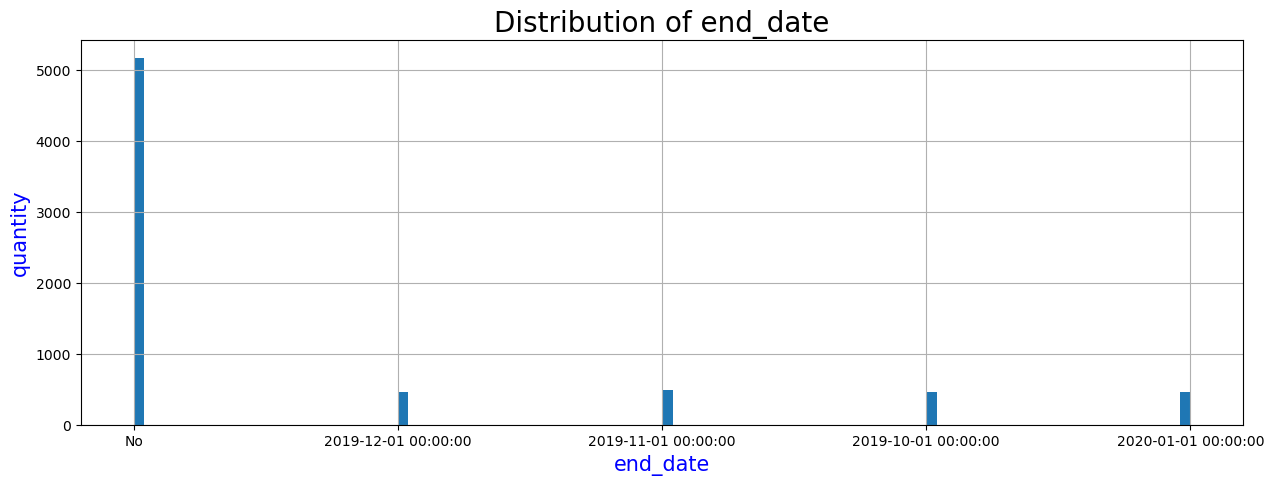

In [1502]:
plt.figure(figsize=(15, 5))
df['end_date'].hist(bins=100)
plt.title('Distribution of end_date', fontsize=20)
plt.xlabel("end_date", fontsize=15, color = 'blue')
plt.ylabel("quantity", fontsize=15, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=10)
plt.xticks(df['end_date'].unique())
#plt.xlim(0,180)
plt.show()

Уход клиентов отмечается с конца 2019 года, хотя даты начала пользования услугами начинаются с 2013 года. Возможно политика/руководство/цены на тарифы компании изменились и (постоянные или новые) клиенты стали уходить.

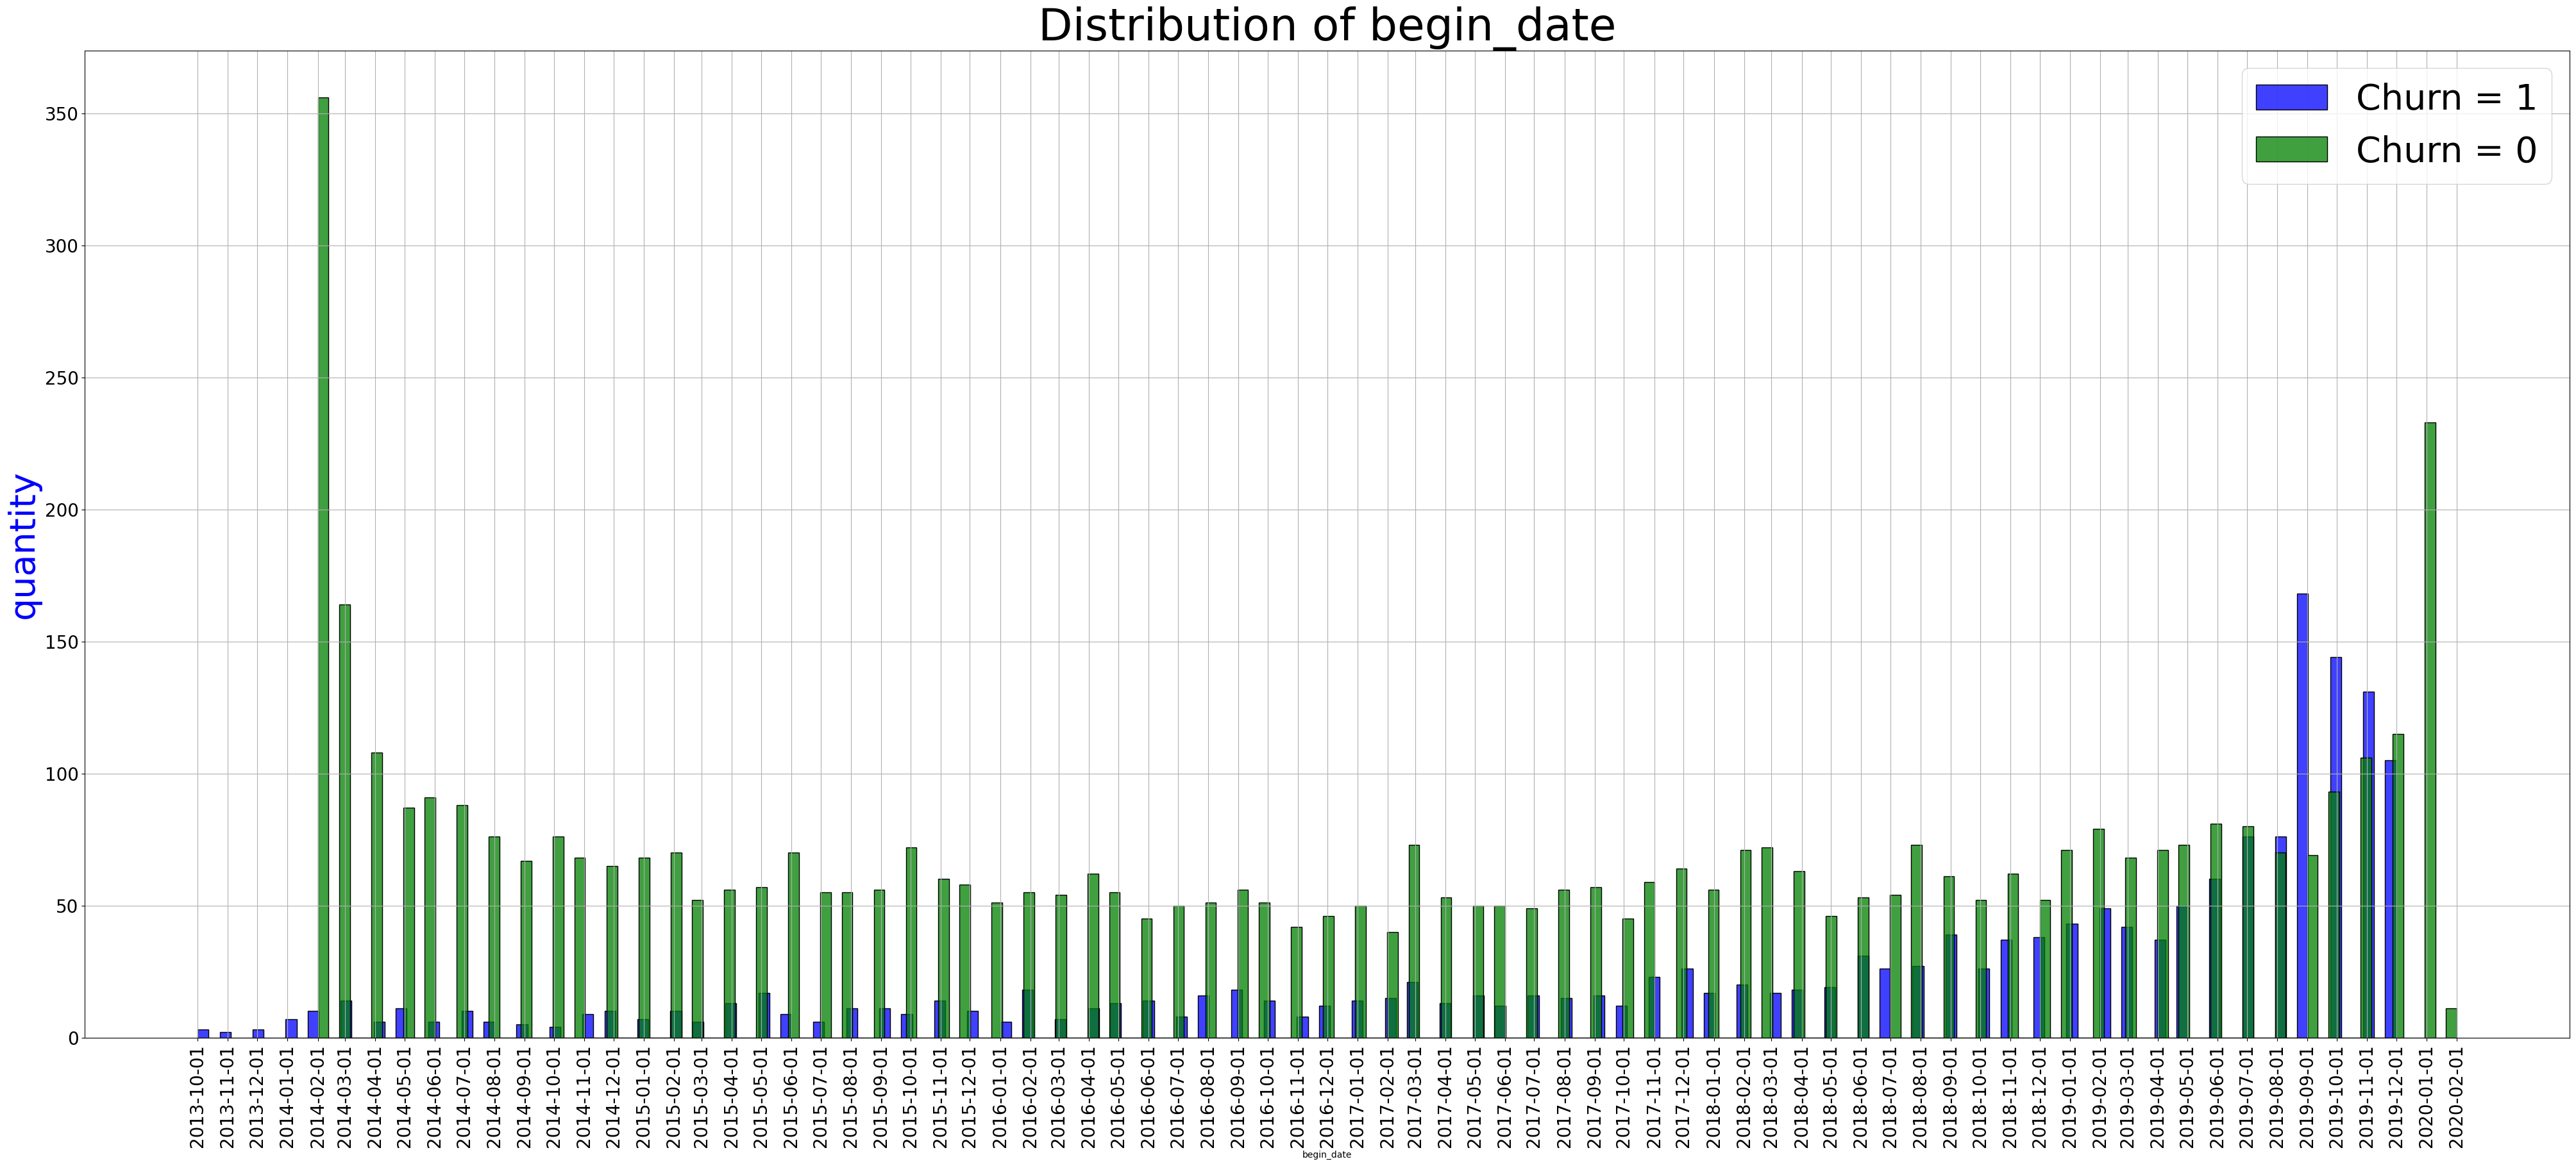

In [1503]:
plt.figure(figsize=(50, 20))
sns.histplot(data=df[df.churn == 1]['begin_date'], bins=200, color='b')
sns.histplot(data=df[df.churn == 0]['begin_date'], bins=200, color='g')
plt.title('Distribution of begin_date', fontsize=50)
#plt.xlabel("begin_date", fontsize=40, color = 'blue')
plt.ylabel("quantity", fontsize=40, color = 'blue')
plt.tick_params(axis='both', which='major', labelsize=20)
plt.xticks(df['begin_date'].unique(), rotation ='vertical')

plt.grid(True)
labels = ['Churn = 1', 'Churn = 0']
plt.legend(labels, fontsize=40)

plt.show()

Действительно в конце 2018 году количество ушедших клиентов стало расти, в конце 2019 года количество таких клиентов максимально. Но нужно учеть количество клиентов в каждый год. возможно, что уходящих клиентов стало больше изза роста клиентов  в целом.

In [1504]:
df['begin_year'] = pd.DatetimeIndex(df['begin_date']).year
df['begin_month'] = pd.DatetimeIndex(df['begin_date']).month

In [1505]:
# Посчитаем количество клиентов компании для каждого месяца без учета ухода клиентов
count_clients_on_month = []
sum = 0
for value in df.groupby(['begin_year', 'begin_month'])['customer_id'].count().sort_index(ascending=True).values:
   sum = sum + value
   count_clients_on_month.append(sum)

In [1506]:
# Посчитаем количество ушедных клиентов компании для каждого месяца
count_left_clients_on_month = df.groupby(['begin_year','begin_month'])['churn'].sum().sort_index(ascending=True).values


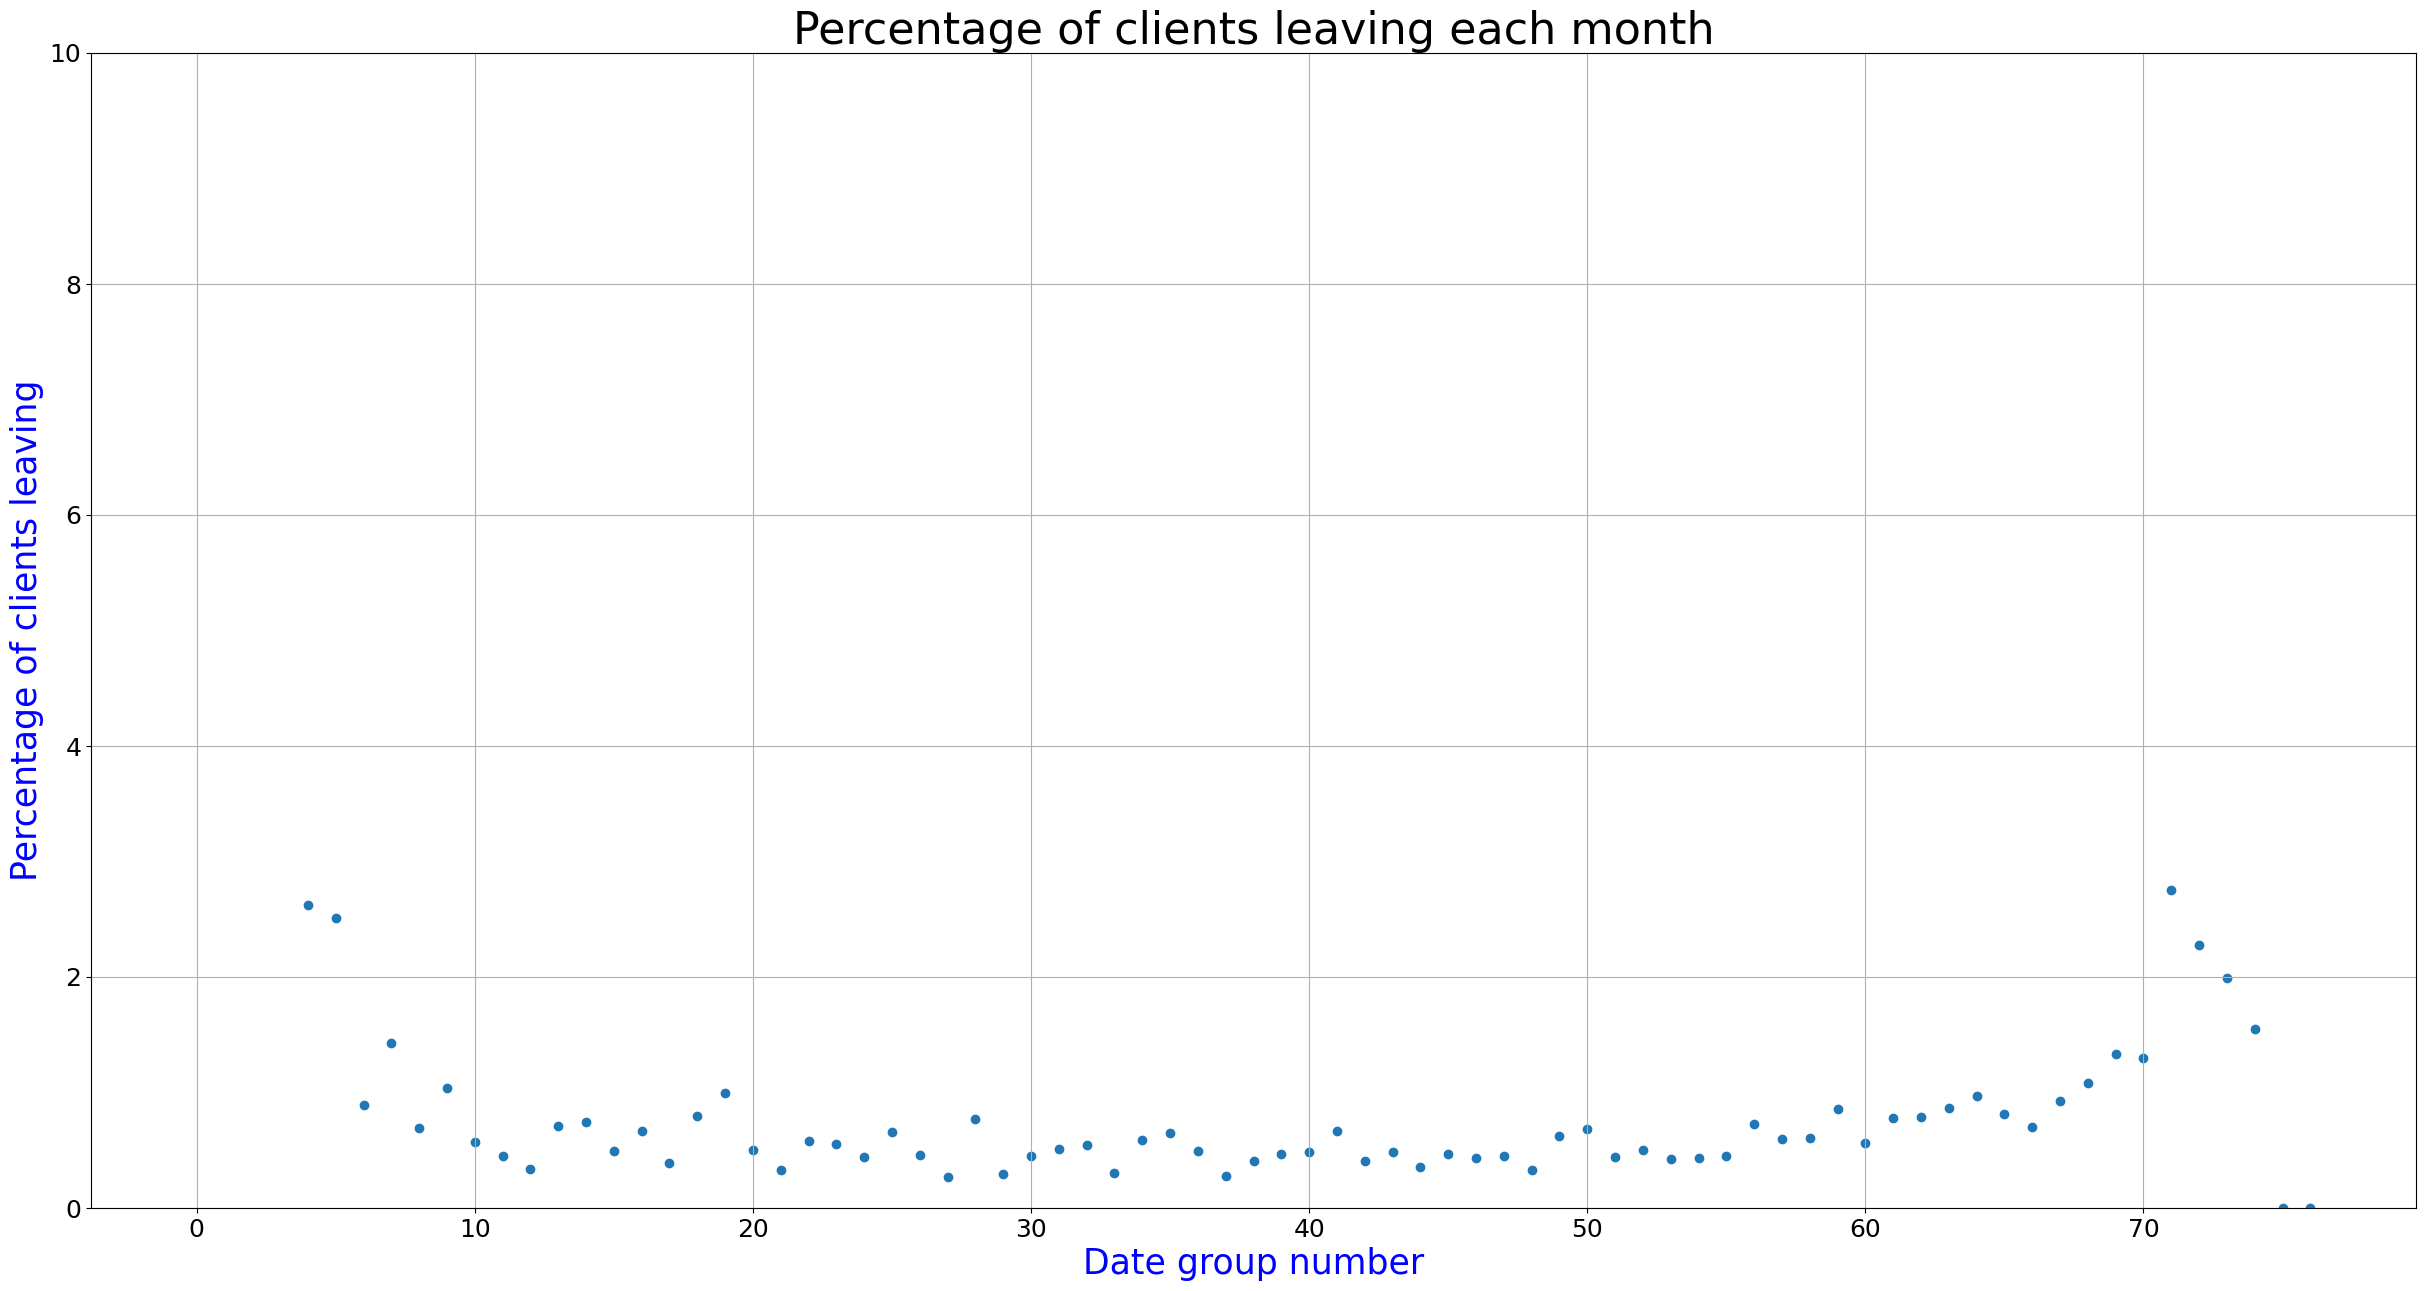

In [1507]:
# Расчет процента оттока клиентов в каждый месяц и визуализация
plt.figure(figsize=(30, 15))
plt.scatter(y=count_left_clients_on_month/count_clients_on_month*100, x=range(len(count_left_clients_on_month/count_clients_on_month*100)))
plt.xlabel("Date group number", fontsize=25, color = 'blue')
plt.ylabel("Percentage of clients leaving", fontsize=25, color = 'blue')
plt.grid()
plt.ylim(0,10)
plt.tick_params(axis='both', which='major', labelsize=18)
plt.title('Percentage of clients leaving each month', fontsize=32)

plt.show()

Последние месяцы процент ухода клиентов вырос не выше чем на 2%, но в целом компания работает стабильно, нет значительных скачков в изменении процента ухода клиентов. begin date можно будет не использовать при предсказании оттока.

In [1508]:
def plot_hist_and_box(series, legend=None):
    ''' Функция построения гистограмм и диаграмм размаха для pd.Series
    
    Параметры 
    ---
        `series` : pd.Series
    '''
    
    fig, axes = plt.subplots(2, 1, figsize=(10, 5),sharex=True)
    # диаграмма размаха 
    sns.boxplot(ax=axes[0], data=series.values, orient='h')
    #axes[1].xticks(range(10,121,10))
    # гистограмма с функцией распределения
    sns.histplot(ax=axes[1], data=series.values ,bins=200, kde=True)
    #plt.tick_params(axis='both', which='major', labelsize=10)
    plt.xlabel(series.name, fontsize=10, color = 'black')
    
    plt.show()

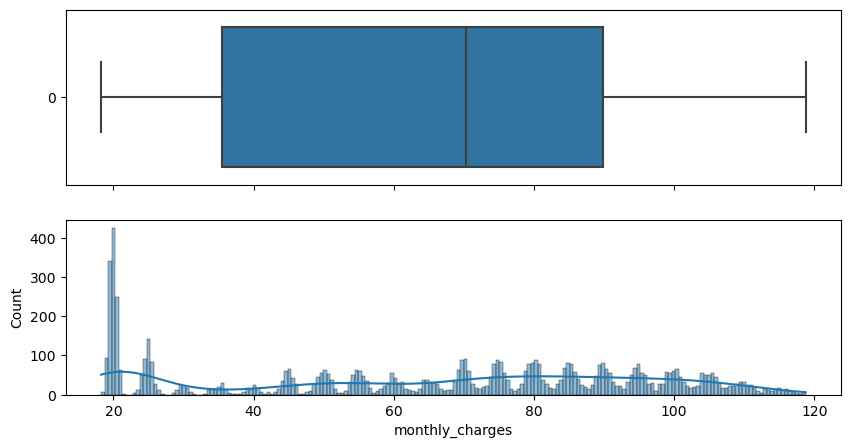

In [1509]:
plot_hist_and_box(df['monthly_charges'])

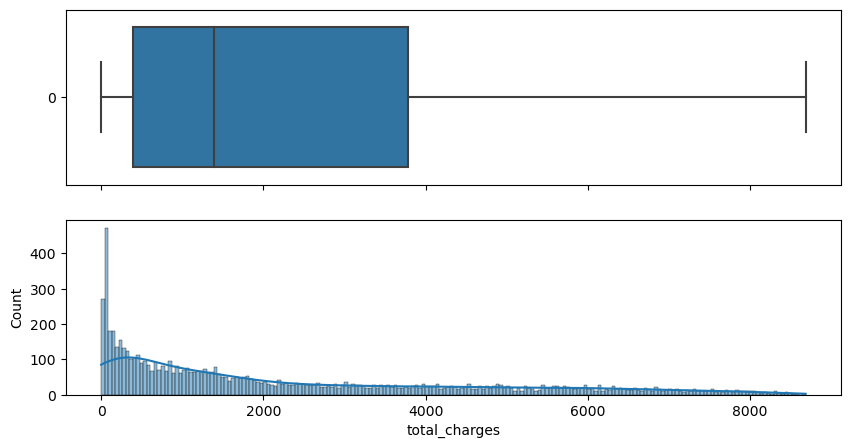

In [1510]:
plot_hist_and_box(df['total_charges'])

- Максимум суммарных трат клиентов близок к 0.
- Первый максимум в распределении значений месячной оплаты  приходится на минимальное значение месячной абонентской платы. 

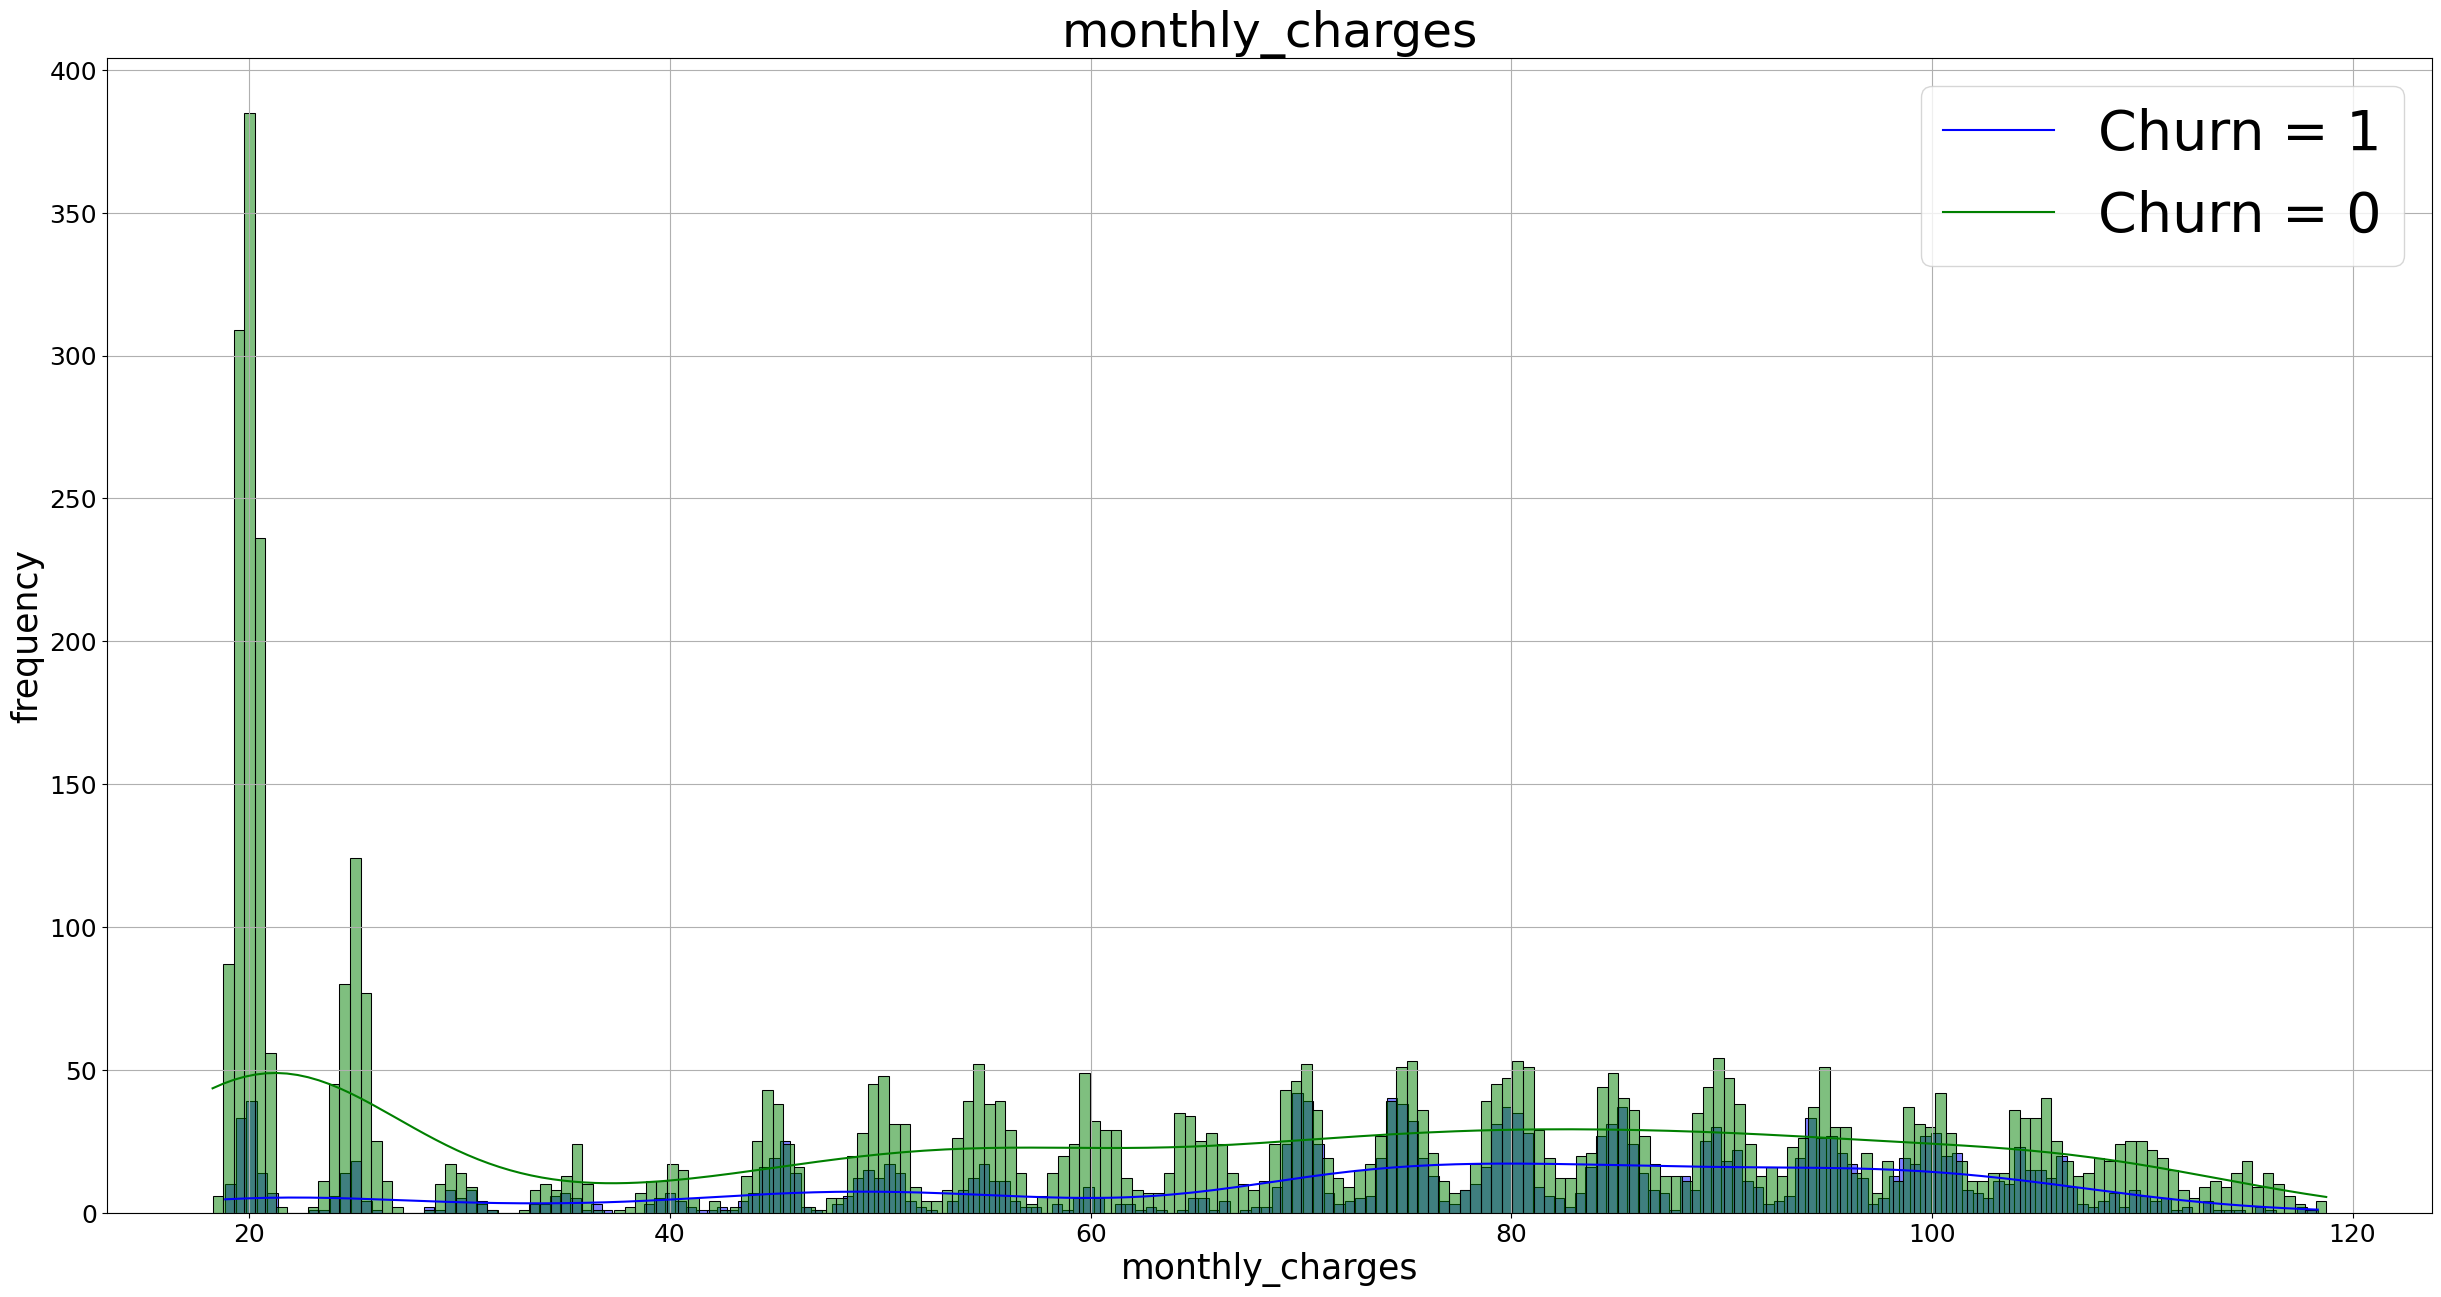

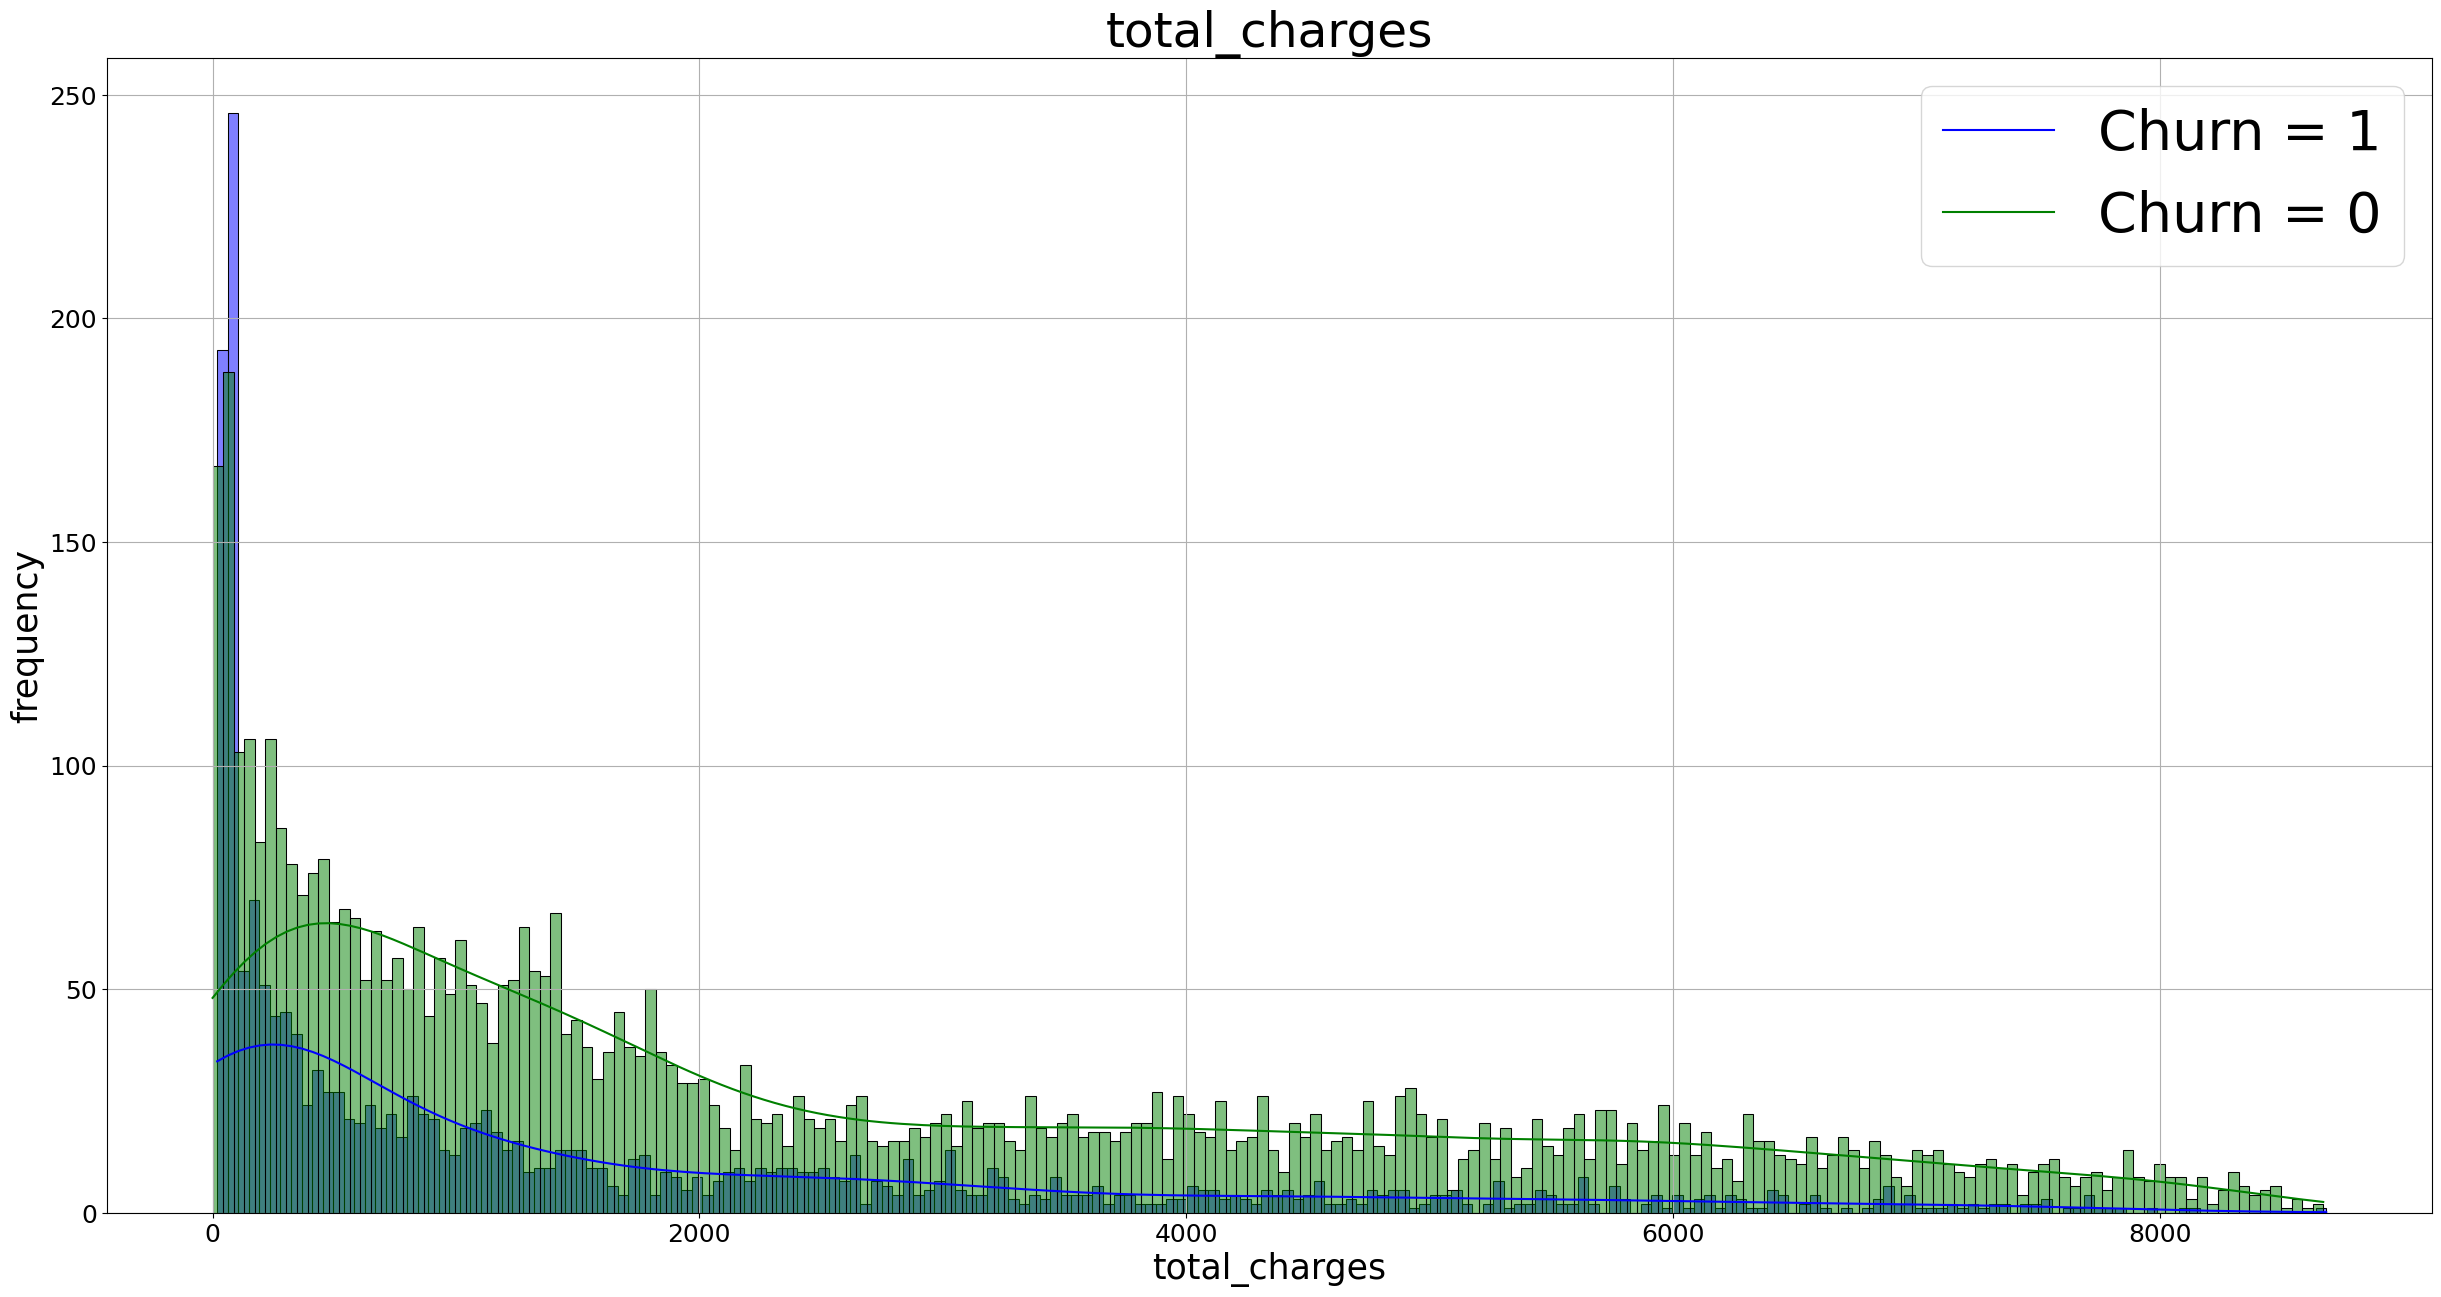

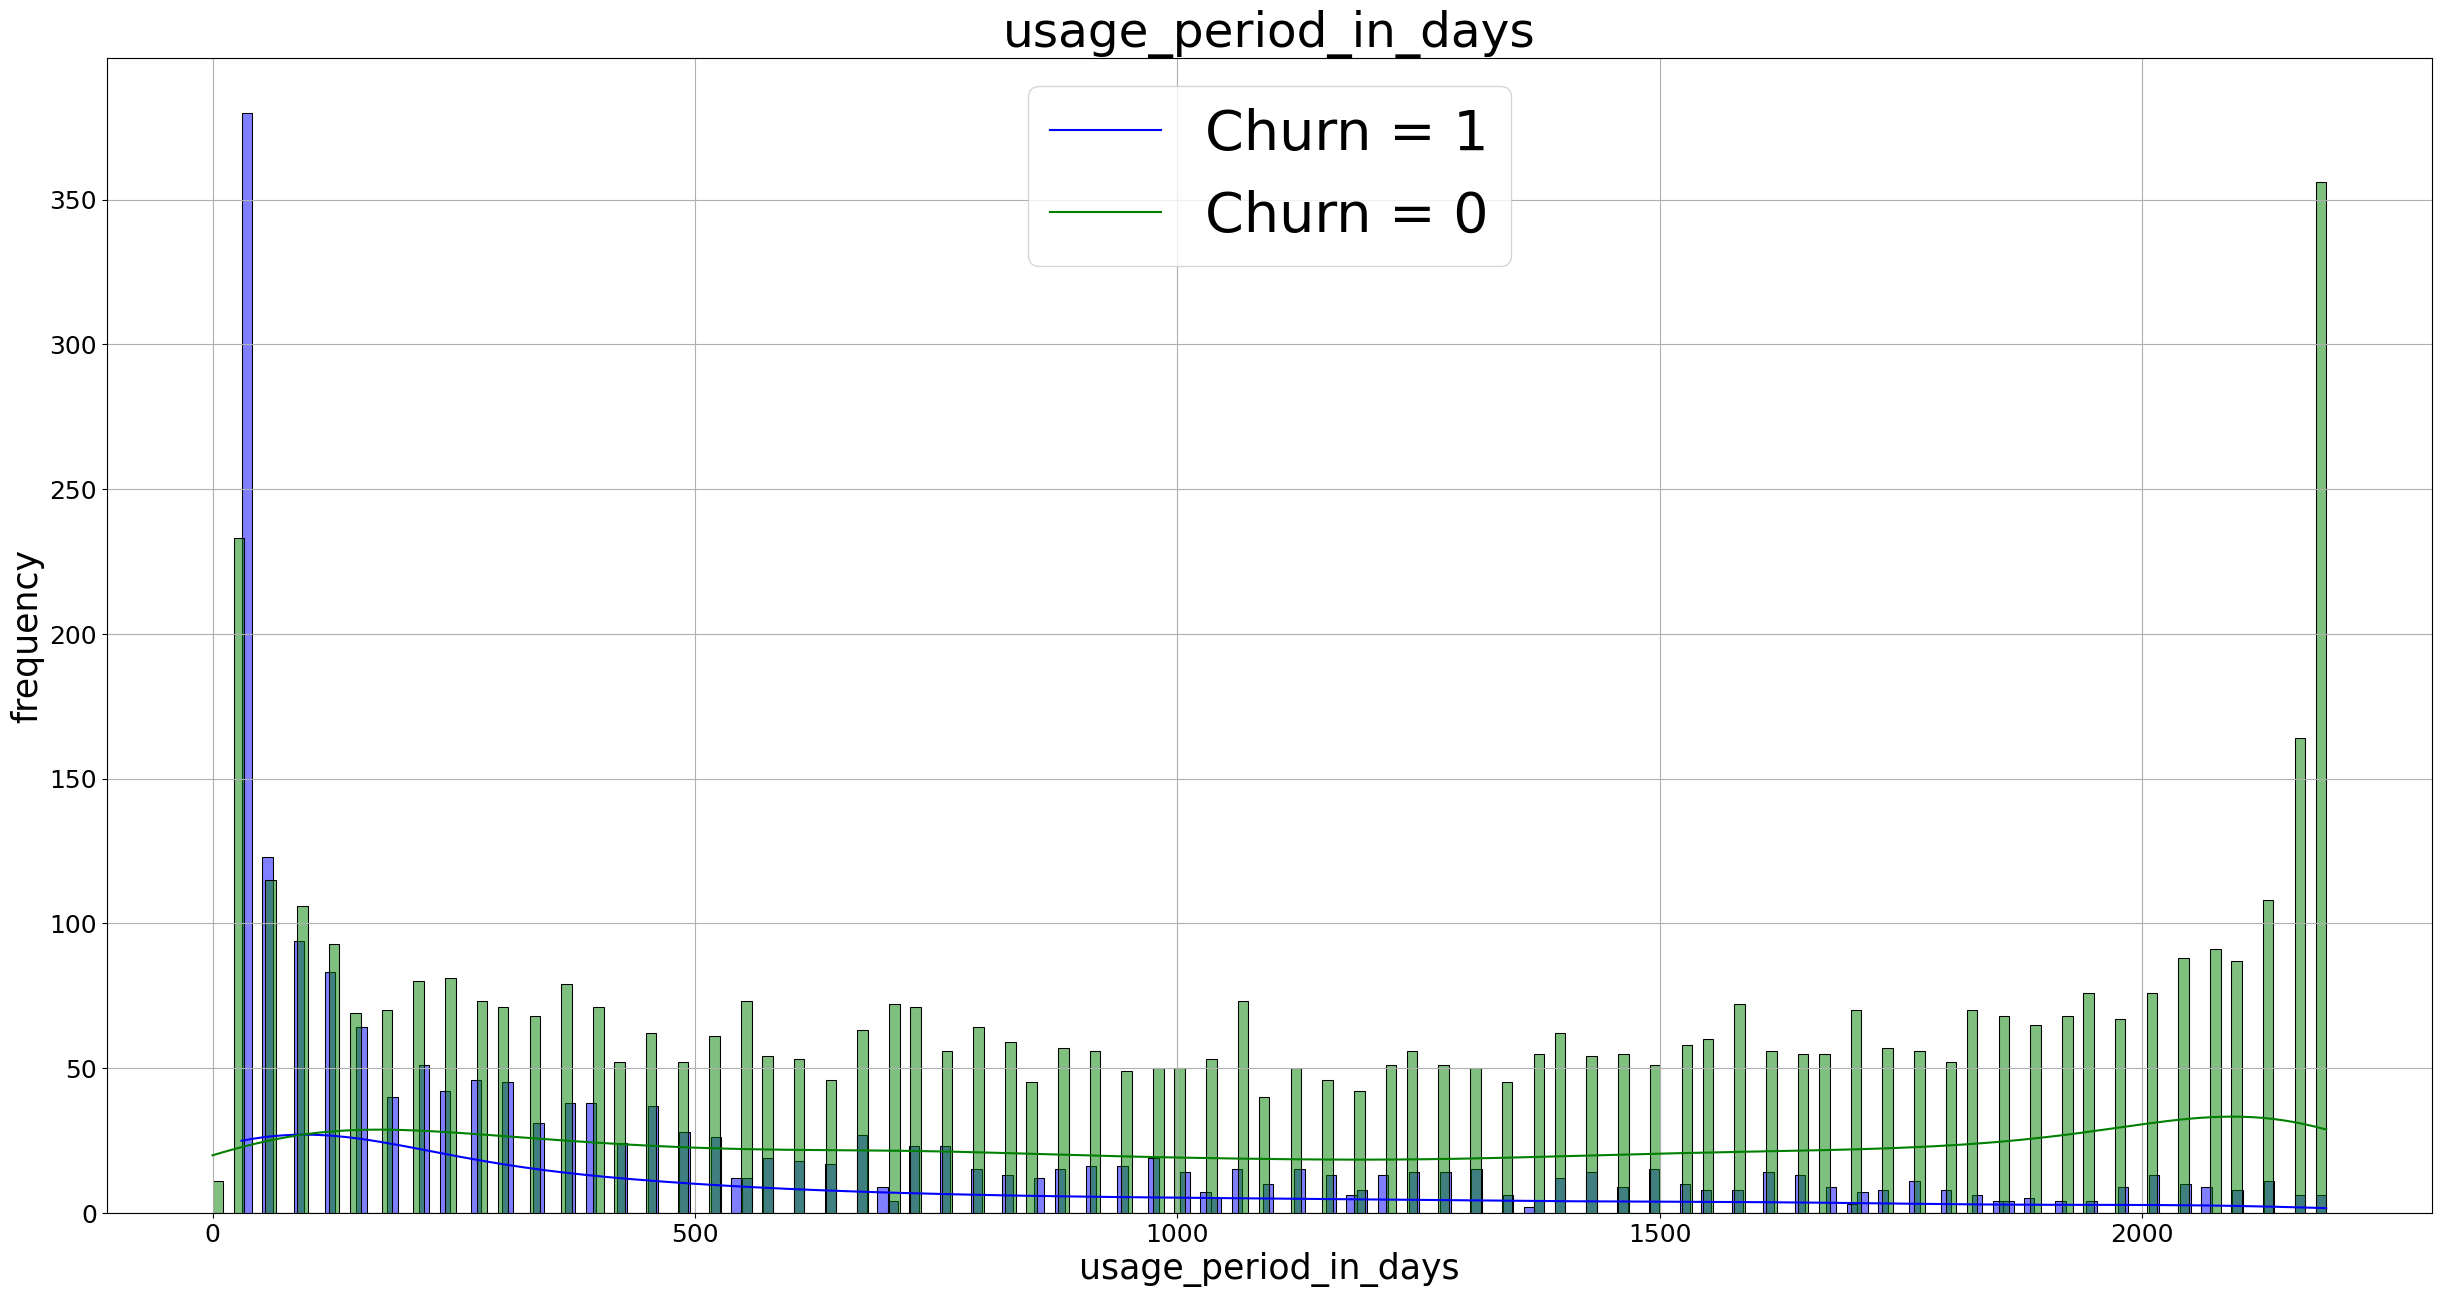

In [1511]:
for f in ['monthly_charges', 'total_charges', 'usage_period_in_days']:
    plt.figure(figsize=(30, 15))
    sns.histplot(data=df[df.churn == 1][f], bins=200, kde=True, color='b')
    sns.histplot(data=df[df.churn == 0][f], bins=200, kde=True, color='g')
   # plt.hist(df[df.churn == 'No'][f], 100, facecolor='g', alpha=0.4)
    #plt.hist(df[df.churn == 'Yes'][f], 100, facecolor='b', alpha=0.4)
    plt.xlabel(f, fontsize=25)
    plt.ylabel('frequency', fontsize=25)
    plt.tick_params(axis='both', which='major', labelsize=18)
    plt.title(f, fontsize=35)
    plt.grid(True)
    labels = ['Churn = 1', 'Churn = 0']
    plt.legend(labels, fontsize=40)
    

    plt.show()

- У ушедших клиентов доля пользователей с высокой абонентской платой выше
- По распредлению суммарных трат сложно делать выводы. 
- Очень большая часть клиентов уходит в первые месяцы подключения. Для них распредение скошено вправо. Клиенты, пользующиеся услугами более 2 лет, уходят в меньшей мере.

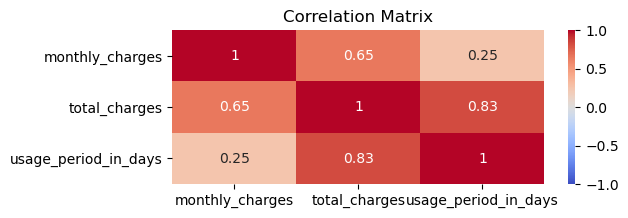

In [1512]:

numeric_features = ['monthly_charges', 'total_charges', 'usage_period_in_days']
sns.heatmap(df[numeric_features].corr(),
            annot=True, cmap='coolwarm', vmin=-1, vmax=1)
plt.title('Correlation Matrix')
plt.show()

Суммарные траты клиентов сильно зависят от времени пользования услугами, что логично. Возможно стоит в последующем удалить один из столбцов, чтобы избавиться от мультиколлинеарности. Также суммарные и месячные траты коррелируют.

Могут быть удалены следующие признаки:

- begin_date и end_date
- gender - не несёт полезной информации, классы сбалансированы
- total_charges - мультиколлинеарный по отношению к usage_period_in_days и monthly_charges
- begin_year, begin_month созданы для исследования, не влияют на целевую переменную

In [1513]:
preprocessed_df = df.drop(columns=['begin_date', 'end_date', 'gender', 'total_charges', 'customer_id', 'begin_year', 'begin_month'])
preprocessed_df.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 7043 entries, 0 to 7042
Data columns (total 17 columns):
 #   Column                Non-Null Count  Dtype   
---  ------                --------------  -----   
 0   type                  7043 non-null   category
 1   paperless_billing     7043 non-null   category
 2   payment_method        7043 non-null   category
 3   monthly_charges       7043 non-null   float64 
 4   senior_citizen        7043 non-null   category
 5   partner               7043 non-null   category
 6   dependents            7043 non-null   category
 7   internet_service      7043 non-null   category
 8   online_security       7043 non-null   category
 9   online_backup         7043 non-null   category
 10  device_protection     7043 non-null   category
 11  tech_support          7043 non-null   category
 12  streaming_tv          7043 non-null   category
 13  streaming_movies      7043 non-null   category
 14  multiple_lines        7043 non-null   category
 15  usag

In [1514]:
cat_features = ['type', 'paperless_billing', 'payment_method', 'senior_citizen', 'partner', 'dependents', 'internet_service', 'online_security', 'online_backup', 'device_protection', 'tech_support', 'streaming_tv','streaming_movies', 'multiple_lines' ]
numeric_features = ['monthly_charges','usage_period_in_days']
preprocessed_df['churn'] = preprocessed_df['churn'].astype('category')

# Обучение моделей


In [1515]:
RANDOM_STATE = 270223

In [1516]:
# разделяем датасет
x_train, x_test, y_train, y_test = train_test_split(
    preprocessed_df.drop('churn', axis=1), preprocessed_df['churn'], test_size=0.25, 
    random_state=RANDOM_STATE )

print('Обучающая выборка: ', x_train.shape, y_train.shape)
print('Тренировочная выборка: ', x_test.shape, y_test.shape)


Обучающая выборка:  (5282, 16) (5282,)
Тренировочная выборка:  (1761, 16) (1761,)


По требованию заказчика для оценки качества модели будем использовать метрику ROC AUC. Для обучения логистической регрессии и дерева решений закодируем категориальные признаки методом OHE, в LGBMClassifier и CatBoostClassifier будем передавать напрямую категориальные признаки.

In [1517]:
cv_params = {'scoring': 'roc_auc',
             'return_train_score': True,
             'cv': 4
             }

## Логистическая регрессия LogisticRegression

In [1518]:
%%time 
pipe = Pipeline([
    ('ohe', ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(sparse=False, drop='first'), cat_features)],
                             )
    ),
    ('scaling', StandardScaler()
    ),
    ('clf', LogisticRegression(random_state=RANDOM_STATE, max_iter=500)
    )
])
params = {'clf__solver': ['lbfgs', 'liblinear'],
          'clf__C': np.logspace(-3, 3, 7),
          'clf__class_weight' : [None, 'balanced']
         } 
grid_lr = GridSearchCV(pipe, params, **cv_params, n_jobs=-1)
grid_lr.fit(x_train, y_train)

print(grid_lr.best_score_)

0.8328750122662257
CPU times: user 249 ms, sys: 34.5 ms, total: 283 ms
Wall time: 1.15 s


## Случайный лес RandomForestClassifier


In [1519]:
%%time
pipe = Pipeline([
    ('ohe', ColumnTransformer(
        transformers=[('ohe', OneHotEncoder(sparse=False, drop='first'), cat_features)]
        )),
    ('clf', RandomForestClassifier(random_state=RANDOM_STATE))
])
params = {'clf__max_depth': range(4, 21, 4),
          'clf__min_samples_leaf': range(1, 11, 1),
          'clf__n_estimators': [10, 50, 100],
          'clf__class_weight' : [None, 'balanced']
         } 
grid_rf = RandomizedSearchCV(pipe, params, **cv_params, random_state=RANDOM_STATE, n_jobs=-1)
grid_rf.fit(x_train, y_train)

print(grid_rf.best_score_)

0.829554162921233
CPU times: user 400 ms, sys: 63.1 ms, total: 463 ms
Wall time: 1.32 s


## LGBMClassifier


In [1520]:
%%time
params = {'learning_rate': [0.1, 0.3, 0.5],
          'n_estimators': [10, 20],
          'class_weight': [None, 'balanced'],
          'lgb__boosting_type' : ['gbdt', 'dart'], 
          'lgb__objective' : ['binary']
          }
grid_lgbm = RandomizedSearchCV(
    LGBMClassifier(categorical_feature = cat_features, random_state=RANDOM_STATE), 
    params, **cv_params, random_state=RANDOM_STATE)

grid_lgbm.fit(x_train, y_train)
grid_lgbm.predict(x_test)


print(grid_lgbm.best_score_)

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-package

[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1487: UserWarning: categorical_feature keyword has been found in `params` and will be ignored.
Please use categorical_feature argument of the Dataset constructor to pass this parameter.
  _log_warning(f'{key} keyword has been found in `params` and will be ignored.\n'
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/lightgbm/basic.py:1513: UserWarning: categorical_feature in param dict is overridden.
  _log_warning(f'{cat_alias} in param dict is overridden.')


[LightGBM] [Warning] Unknown parameter: lgb__boosting_type
[LightGBM] [Warning] Unknown parameter: lgb__objective
0.8959453067441246
CPU times: user 20.6 s, sys: 7.14 s, total: 27.7 s
Wall time: 8.06 s


## CatBoostClassifier

In [1528]:
%%time
params = {'depth': [4, 8, 15],
          'l2_leaf_reg': [1, 3, 5, 7],
          'learning_rate': [0.3, 0.5, 0.8],
          'n_estimators': [10, 30,40]
          }
grid_ctb = RandomizedSearchCV(
    CatBoostClassifier(loss_function="Logloss"), 
    params, **cv_params, random_state=RANDOM_STATE)
grid_ctb.fit(x_train, y_train, cat_features=cat_features, verbose=0)

print(grid_ctb.best_score_)

/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, la

0.8843823282127123
CPU times: user 2min 17s, sys: 1min, total: 3min 18s
Wall time: 1min 54s


/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, label, cat_features, text_features, embedding_features, pairs, weight, group_id, group_weight, subgroup_id, pairs_weight, baseline, timestamp, feature_names, thread_count)
/Users/uliana/opt/anaconda3/envs/practicum/lib/python3.9/site-packages/catboost/core.py:1171: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  self._init_pool(data, la

На кроссвалидации лучшую метрику AUC-ROC выдал CatBoost, LGBM показывает признаки переобучения, но метрика также высокая и обучается намного быстрее.

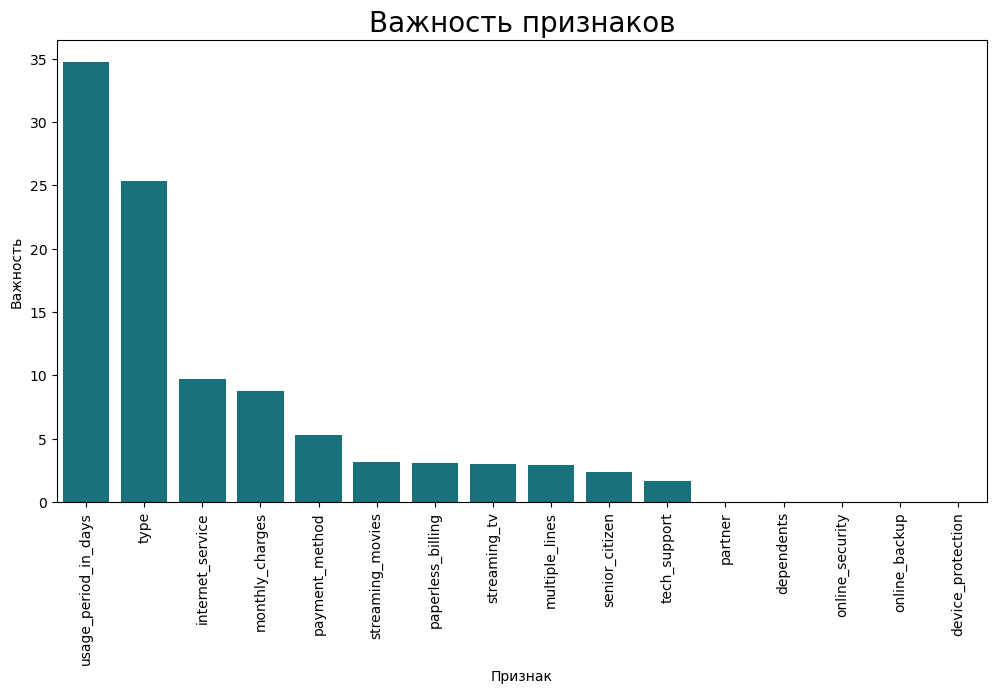

In [1522]:
importances = pd.DataFrame(data={
          'Attribute': x_train.columns,
          'Importance':grid_ctb.best_estimator_.feature_importances_
      })
importances = importances.sort_values(by='Importance', ascending=False)
plt.figure(figsize = (12,6))
sns.barplot(x=importances['Attribute'], y=importances['Importance'], color='#087E8B')
plt.title('Важность признаков', size=20)
plt.xticks(rotation='vertical')
plt.xlabel('Признак')
plt.ylabel('Важность')
plt.show()

Самые важные признаки - время использования услуг и ежемесечная плата. Их важность в несколько раз выше, чем у остальных признаков.

## Тестирование

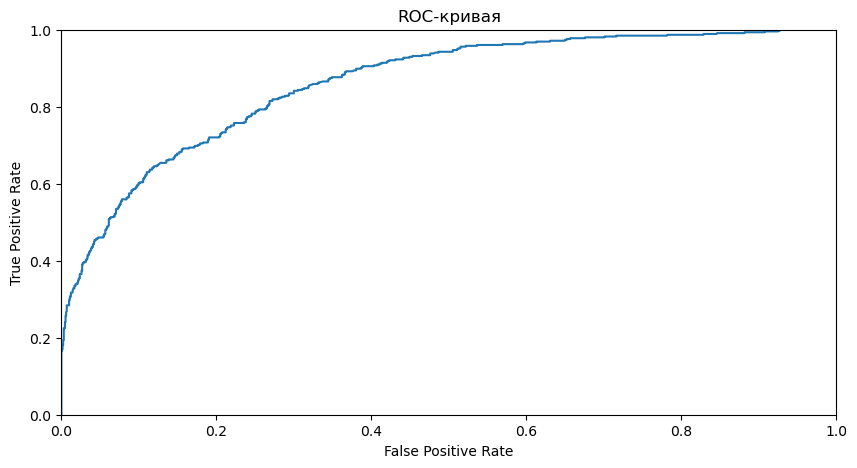

Показатели roc auc: 0.861073379869156


In [1529]:
probabilities_test = grid_ctb.predict_proba(x_test)
probabilities_one_test = probabilities_test[:, 1]
fpr, tpr, thresholds = roc_curve(y_test, probabilities_one_test)
plt.figure(figsize=(10, 5))
plt.plot(fpr, tpr)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.0])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC-кривая')
plt.show() 
auc_roc = roc_auc_score(y_test, probabilities_one_test)
print('Показатели roc auc:', auc_roc)

In [1530]:
grid_ctb.best_params_ # Лучшие гиперпараметры модели

{'n_estimators': 40, 'learning_rate': 0.5, 'l2_leaf_reg': 1, 'depth': 8}

# Вывод

Проанализирована работа нескольких моделей для предсказания оттока клиентов по предоставленным данным.

Для минимизации рисков трат бюджета на промоакции для клиентов, которые не собираются уходить, и вовремя спрогнозировать уход клиента необходима модель с минимальными ложно-положительными и ложно-отрицательными предсказаниями. Из рассмотренных моделей CatBoostClassifier с гиперпараметрами 'n_estimators': 20, 'learning_rate': 0.3, 'l2_leaf_reg': 7, 'depth': 4 будет предпочтительнее.  
AUC-ROC = 0.86

Из анализа данных также можно было заметить, что вероятнее всего

- Большая часть клиентов уходит из-за высокой стоимости услуг
- Особое внимание в планировании промоакции необходимо уделить клиентам, подключённым к интернет по оптоволокну
- То же касается клиентов с ежемесячной оплатой
- Очень большая часть клиентов уходит в первые месяцы подключения, это следует учитывать при проведении промокомпаний

# Отчет
### Загрузка данных и изучение общей информации 
Данные загружены, изучено количество столбцов, строк, изучены статистические показатели.
### Подготовка данных :  
Таблицы до соединения не имели пропусков и дубликатов, имели общий стобец customer_id.  
Таблица после объединения таблиц:  
- 20 столбцов
- 7043 строк
- 10 категориальных столбцов (9 bool, 1 numeric)
- отсутствие дубликатов
- 11364 пропущенных значений  
  
Пропуски образовавшиеся при обьединении таблиц заполнены категорией "No". Был добавлен в датафрейм новый столбец период пользования услугами компании в днях usage_period_in_days. Был добавлен целевой признак churn. Если значение в столбце EndDate равно "No", то значит клиент не ушел и целевой признак равен 0. Если дата ухода есть, то целевой признак равен 1.  
### Исследовательский анализ
- Исследована зависимости признаков от целевого признака - факта ухода клиента
- Удалены мультиколлинеарные признак total_charges, незначимый признак gender, begin_date, end_date, customer_id
- Обнаружена небалансированность классов
- Отобраны признаки для обучения
### Построение и обучение моделей  
Были использованы для обучения следующие признаки:    
- type                 
- paperless_billing   
- payment_method       
- monthly_charges
- senior_citizen      
- partner              
- dependents            
- internet_service      
- online_security       
- online_backup        
- device_protection   
- tech_support         
- streaming_tv         
- streaming_movies    
- multiple_lines     
- usage_period_in_days 
- churn   
  
Построены и обучены с использованием кросс-валидации модели линейной регресси, случайного леса и случайного леса с градиентным усилением (LGBMClassifier и CatBoostClassifier). Подбор гиперпараметров выполнен с использование gridsearch.  Вычислена заданная метрика AUC-ROC и выбрана лучшая модель (CatBoostClassifier). Протестирована модель CatBoostClassifier.  
  
    - Итоговая модель:     
    CatboostClassifier('n_estimators': 40, 'learning_rate': 0.5, 'l2_leaf_reg': 1, 'depth': 8, 'cbc__loss_function' = 'Logloss', random_state = 270223, auto_class_weights = 'Balanced'). roc_auc : 0.86. Размер тестовой выборки: (1761,) (25%).

Отличия от исходного плана: не обнаружены.  
#### Ключевые этапы:
- Добавление признаков, поскольку датасет был предоставлен без целевой метки. А добавленный признак продолжительности использования услуг оказался наиболее значимым
- Исследовательский анализ, поскольку он помогает найти закономерности в поведении клиентов 
#### Трудности
Решить проблему переобучения моделей CatBoostClassifier и LGBMClassifier. Удалось решить с помощью подбора гиперпараметров, в частности увеличения learning_rate 
